### 数据说明
    Revenue 门店销售额

    Reach 微信推送次数

    Loval_tv 本地电视广告投入
    Online 线上广告投入
    Instore 门店内海报陈列等投入
    Person 门店销售人员投入
    Event 门店促销事件（cobranding 品牌联合促销 holiday 节假日 special 门店特别促销 non-event 无促销活动）


### 数据导出与数据清理

In [1]:
import pandas as pd 
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [2]:
df=pd.read_csv('./data/baojie.csv')
df=df.dropna()

In [3]:
df.head()

,Unnamed: 0,revenue,reach,local_tv,online,instore,person,event
0,845,45860.28,2,31694.91,2115,3296,8,non_event
1,483,63588.23,2,35040.17,1826,2501,14,special
2,513,23272.69,4,30992.82,1851,2524,6,special
3,599,45911.23,2,29417.78,2437,3049,12,special
4,120,36644.23,2,35611.11,1122,1142,13,cobranding


In [4]:
df=np.nan_to_num(df)

In [5]:
df.shape

(929, 8)

In [6]:
df=pd.DataFrame(data=df,columns=['0','revenue','reach','loacl_tv','online','instore','person','event'])

In [7]:
df.head()

,0,revenue,reach,loacl_tv,online,instore,person,event
0,845,45860.28,2,31694.91,2115,3296,8,non_event
1,483,63588.23,2,35040.17,1826,2501,14,special
2,513,23272.69,4,30992.82,1851,2524,6,special
3,599,45911.23,2,29417.78,2437,3049,12,special
4,120,36644.23,2,35611.11,1122,1142,13,cobranding


In [8]:
del df['0']

In [9]:
df.head()

,revenue,reach,loacl_tv,online,instore,person,event
0,45860.28,2,31694.91,2115,3296,8,non_event
1,63588.23,2,35040.17,1826,2501,14,special
2,23272.69,4,30992.82,1851,2524,6,special
3,45911.23,2,29417.78,2437,3049,12,special
4,36644.23,2,35611.11,1122,1142,13,cobranding


In [10]:
y=df['revenue']
del df['revenue']


In [11]:
df.head()

,reach,loacl_tv,online,instore,person,event
0,2,31694.91,2115,3296,8,non_event
1,2,35040.17,1826,2501,14,special
2,4,30992.82,1851,2524,6,special
3,2,29417.78,2437,3049,12,special
4,2,35611.11,1122,1142,13,cobranding


- 将事件这一栏的种类名称替换成对应的数字

In [12]:
from sklearn import preprocessing
le=preprocessing.LabelEncoder()
species_encoded=le.fit_transform(df['event'])
df['event']=species_encoded
df.head()

,reach,loacl_tv,online,instore,person,event
0,2,31694.91,2115,3296,8,2
1,2,35040.17,1826,2501,14,3
2,4,30992.82,1851,2524,6,3
3,2,29417.78,2437,3049,12,3
4,2,35611.11,1122,1142,13,0


### 将数据集分为训练集和测试集

In [13]:
df['random']=np.random.random(size=len(df))
X_train,X_test,y_train,y_test=train_test_split(df,y,test_size=0.8,random_state=10)

In [14]:
df=df[['reach','loacl_tv','online','instore','person']].apply(lambda x:x.astype(float))

In [15]:
corrMatrix=df.corr()
corrMatrix

,reach,loacl_tv,online,instore,person
reach,1.000000,-0.034039,-0.033271,0.036588,0.057563
loacl_tv,-0.034039,1.000000,0.006775,-0.046825,0.048664
online,-0.033271,0.006775,1.000000,-0.020198,0.035069
instore,0.036588,-0.046825,-0.020198,1.000000,-0.008875
person,0.057563,0.048664,0.035069,-0.008875,1.000000


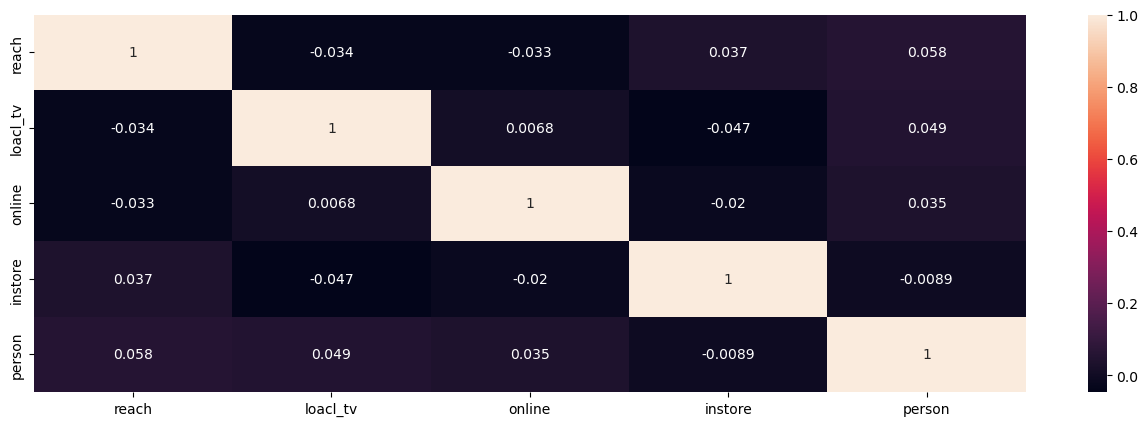

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16,5),dpi=100)
sns.heatmap(corrMatrix,annot=True)
plt.show()

- 从上述图可以发现这个数据集没有很明显的关系

- 使用随机森林进行建模

In [17]:
from sklearn.ensemble import RandomForestRegressor

rf=RandomForestRegressor(n_estimators=100,n_jobs=-1,oob_score=True,bootstrap=True,random_state=10)
rf.fit(X_train,y_train)
print('R^2 Training score:{:.2f} \n 00B Score:{:.2f}\n R^2 test score{:.2f}'.format(rf.score(X_train,y_train),
                                                                                   rf.oob_score_,
                                                                                   rf.score(X_test,y_test)))

R^2 Training score:0.96 
 00B Score:0.71
 R^2 test score0.63


- oob score指的是袋外数据得分，可以看出这里overfitting

In [18]:
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

In [19]:
def r2(rf,X_train,y_train):
    return r2_score(y_train,rf.predict(X_train))
perm_imp_rfpimp=permutation_importances(rf,X_train,y_train,r2)

<AxesSubplot:xlabel='Feature'>

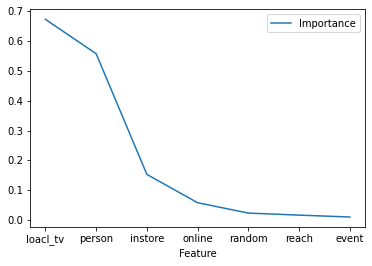

In [21]:
perm_imp_rfpimp.iloc[:,[0]].plot()

- 从这张图可以看出local_tv，person,和instore为前三个最有影响力的变量


### 这里再使用一个更加准确的方法

- 不仅能够判断出哪个变量更重要，还能建议哪些变量可以被移除从而建立更加精准的模型

In [23]:
from sklearn.base import clone

def imp_df(column_names,importances):
    data={
        'Feature':column_names,
        'Importance': importances,
    }
    df=pd.DataFrame(data).set_index('Feature').sort_values('Importance',ascending=False)
    return df

In [25]:
def drop_col_feat_imp(model,X_train,y_train,random_state=10):
    model_clone=clone(model)
    model_clone.random_state=random_state
    model_clone.fit(X_train,y_train)
    benchmark_score=model_clone.score(X_train,y_train)
    
    importances = []
    for col in X_train.columns:
    model_clone=clone(model)
    model_clone.random_state

- 用clone备份一下模型，用于与之后建立的移除某个变量后的模型对比哪个模型的准确性更高